## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from math import radians, cos, sin, asin, sqrt
import datetime as dt

import sklearn.metrics as metrics

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from xgboost.sklearn import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", 60)
pd.set_option("display.max_rows", 500)
%matplotlib inline
sns.set()

/home/dev/virtualenvs/ga-dsi-capstone/local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
### Regression Evaluation Metrics and Diagnostic Plots

def r2_adj(y_true, y_preds, p):
    n = len(y_true)
    y_mean = np.mean(y_true)
    numerator = np.sum(np.square(y_true - y_preds)) / (n - p - 1)
    denominator = np.sum(np.square(y_true - y_mean)) / (n - 1)
    return (1 - (numerator / denominator))

def get_regression_metrics(y_true, y_pred, p):
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
#     msle = metrics.mean_squared_log_error(y_true, y_pred)
    mae = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    r2a = r2_adj(y_true, y_pred, p)
    
    print('Mean squared error      = ', mse)
    print('Root mean squared error = ', rmse)
#     print('Mean squared log error  = ', msle)
    print('Median absolute error   = ', mae)
    print('R^2                     = ', r2)
    print('Adjusted R^2            = ', r2a)
    
    return {
        'mse': mse,
        'rmse': rmse,
#         'msle': msle,
        'mae': mae,
        'r2': r2,
        'r2_adjusted': r2a
    }

def regression_diagnostic_plots(df_true_pred, filename):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    axes = axes.ravel()
    
    
    # Residual Plot: Validating the assumption of linearity
    sns.residplot('pred', 'true', data=df_true_pred,lowess=True,
                  line_kws={'color': 'red', 'lw': 1, 'alpha': 1}, 
                  ax=axes[0])
    axes[0].set_title('Residual Plot')
    axes[0].set_ylabel('Residuals')
    axes[0].set_xlabel('Fitted Values')
    
    residuals = df_true_pred['true'] - df_true_pred['pred']
    
    # Normal Q-Q Plot: Validating the assumption of normally distributed residuals (errors)
    stats.probplot(residuals, dist='norm', plot=axes[1])
    axes[1].set_title('Normal Q-Q Plot')
    
    
    # Scale-Location plot: Validating the assumption of homoscedasticity of residuals
    model_norm_residuals_abs_sqrt=np.sqrt(np.abs(residuals))

    sns.regplot(df_true_pred['pred'], model_norm_residuals_abs_sqrt,
                scatter=True,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, 
                ax=axes[2])
    axes[2].set_title("Scale-Location Plot")
    axes[2].set_ylabel("Standarized Residuals")
    axes[2].set_xlabel("Fitted Values")
    
    axes[3].axis('off')
    
    fig.tight_layout()
    fig.savefig('../images/02a-modeling-every-time-point/{}.png'.format(filename), transparent=True)

In [3]:
def gridsearch_model_evaluation(model_name, model, hyper_param, joblib_filename, diagnostic_filename):
    reg_pipe = Pipeline([
        ('reg', model)
    ])
  
#     print(reg_pipe.get_params().keys())
    gs = GridSearchCV(reg_pipe, 
                      param_grid=hyper_param, 
                      verbose=10, 
                      n_jobs=-1)
    gs.fit(X_train_sc, y_train)
    
    print(model_name)
    print('Best Score: {}'.format(gs.best_score_))
    print('Best Params: {}'.format(gs.best_params_))
    
    # Best Model
    grid_model = gs.best_estimator_
    joblib.dump(grid_model, joblib_filename, compress=1)
    
    print()
    
    # Prediction and score
    y_test_pred = grid_model.predict(X_test_sc)

    test_regression_metrics = get_regression_metrics(y_test, y_test_pred, X_test.shape[1])
    test_regression_metrics['model_name'] = model_name
    
    df_test_true_pred = pd.DataFrame(columns=['true', 'pred'])
    df_test_true_pred = df_test_true_pred.assign(true=y_test)
    df_test_true_pred = df_test_true_pred.assign(pred=y_test_pred)
    df_test_true_pred['diff'] = df_test_true_pred['true'] - df_test_true_pred['pred']
    regression_diagnostic_plots(df_test_true_pred, diagnostic_filename)
    
    return test_regression_metrics, y_test_pred, grid_model

In [4]:
def plot_barchart(figsize_tuple, series, filename, model_name):
    # Plot barchart
    plt.figure(figsize=figsize_tuple)

    sns.barplot(y=series.index, x=series.values, orient='h')
    plt.title('Coefficients in the {} model'.format(model_name), fontsize=12)
    plt.savefig('../images/02a-modeling-every-time-point/{}.png'.format(filename), transparent=True)
    
def plot_coefficients(coef, filename, model_name):
    coef = pd.Series(coef, index=X_train.columns)
    plot_barchart((8,5), coef, filename, model_name)
    
# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title, filename):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 12)
    plt.savefig('../images/02a-modeling-every-time-point/{}.png'.format(filename), transparent=True)

## Read Data

In [5]:
df_twn_hkg_flights = pd.read_csv('../data/filtered_flights_twn_hkg.csv', index_col=0)

In [6]:
df_twn_hkg_flights.head()

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed,timestamp_dt,flight_callsign,aircraft_model,aircraft_registration,airline,origin,destination,scheduled_departure_utc,scheduled_arrival_utc,real_departure_utc,estimated_arrival_utc,real_flight_duration,scheduled_departure_dt,scheduled_arrival_dt,real_departure_dt,estimated_arrival_dt,scheduled_flight_duration,route,forecasted_arrival_dt,forecasted_arrival_dt_nearest_hr,arrivals,timestamp_dt_weather,air_temp,...,wind_speed,altimeter_pressure,visibility,gust_speed,sky_level_1_coverage,sky_level_1_altitude,weather_codes,apparent_temp,weather_codes_+SHRA,weather_codes_+TSRA,weather_codes_-BR,weather_codes_-DZ,weather_codes_-RA,weather_codes_-SHRA,weather_codes_BR,weather_codes_DZ,weather_codes_HZ,weather_codes_RA,weather_codes_SHRA,weather_codes_TSRA,weather_codes_VCTS,speed_interval,time_since_real_departure,prev_latitude,prev_longitude,calculated_flight_duration,calculated_time_before_arrival,displacement_to_hkg,displacement_fr_twn,minutes_since_real_departure_interval
0,c0aabc0,1483194745,25.090073,121.237190,950,46,143,2016-12-31 14:32:25,CAL,Boeing 747,B-18717,China Airlines Cargo,Taiwan Taoyuan International Airport,Hong Kong International Airport,1.483193e+09,1.483198e+09,1.483195e+09,NaN,4663.0,2016-12-31 14:00:00,2016-12-31 15:30:00,2016-12-31 14:32:05,NaN,5400.0,Taiwan Taoyuan International Airport -> Hong K...,2016-12-31 15:49:48,2016-12-31 15:00:00,6,2016-12-31 15:00:00,66.2,...,10.0,30.18,6.21,0,FEW,2500,NaN,66.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100 < speed <= 200,20.0,25.072781,121.218529,5115.0,5095.0,806.651564,2.544945,0 <= min <= 10
1,c0aabc0,1483194754,25.093964,121.242012,1375,48,145,2016-12-31 14:32:34,CAL,Boeing 747,B-18717,China Airlines Cargo,Taiwan Taoyuan International Airport,Hong Kong International Airport,1.483193e+09,1.483198e+09,1.483195e+09,NaN,4663.0,2016-12-31 14:00:00,2016-12-31 15:30:00,2016-12-31 14:32:05,NaN,5400.0,Taiwan Taoyuan International Airport -> Hong K...,2016-12-31 15:49:48,2016-12-31 15:00:00,6,2016-12-31 15:00:00,66.2,...,10.0,30.18,6.21,0,FEW,2500,NaN,66.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100 < speed <= 200,29.0,25.090073,121.237190,5115.0,5086.0,807.260143,3.189686,0 <= min <= 10
2,c0aabc0,1483194770,25.101013,121.251183,2100,50,153,2016-12-31 14:32:50,CAL,Boeing 747,B-18717,China Airlines Cargo,Taiwan Taoyuan International Airport,Hong Kong International Airport,1.483193e+09,1.483198e+09,1.483195e+09,NaN,4663.0,2016-12-31 14:00:00,2016-12-31 15:30:00,2016-12-31 14:32:05,NaN,5400.0,Taiwan Taoyuan International Airport -> Hong K...,2016-12-31 15:49:48,2016-12-31 15:00:00,6,2016-12-31 15:00:00,66.2,...,10.0,30.18,6.21,0,FEW,2500,NaN,66.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100 < speed <= 200,45.0,25.093964,121.242012,5115.0,5070.0,808.403669,4.392177,0 <= min <= 10
3,c0aabc0,1483194776,25.103577,121.254631,2300,50,159,2016-12-31 14:32:56,CAL,Boeing 747,B-18717,China Airlines Cargo,Taiwan Taoyuan International Airport,Hong Kong International Airport,1.483193e+09,1.483198e+09,1.483195e+09,NaN,4663.0,2016-12-31 14:00:00,2016-12-31 15:30:00,2016-12-31 14:32:05,NaN,5400.0,Taiwan Taoyuan International Airport -> Hong K...,2016-12-31 15:49:48,2016-12-31 15:00:00,6,2016-12-31 15:00:00,66.2,...,10.0,30.18,6.21,0,FEW,2500,NaN,66.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100 < speed <= 200,51.0,25.101013,121.251183,5115.0,5064.0,808.830179,4.838551,0 <= min <= 10
4,c0aabc0,1483194782,25.107010,121.259155,2525,50,171,2016-12-31 14:33:02,CAL,Boeing 747,B-18717,China Airlines Cargo,Taiwan Taoyuan International Airport,Hong Kong International Airport,1.483193e+09,1.483198e+09,1.483195e+09,NaN,4663.0,2016-12-31 14:00:00,2016-12-31 15:30:00,2016-12-31 14:32:05,NaN,5400.0,Taiwan Taoyuan International Airport -> Hong K...,2016-12-31 15:49:48,2016-12-31 15:00:00,6,2016-12-31 15:00:00,66.2,...,10.0,30.18,6.21,0,FEW,2500,NaN,66.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [7]:
df_twn_hkg_flights['scheduled_departure_dt'] = pd.to_datetime(df_twn_hkg_flights['scheduled_departure_dt'])
df_twn_hkg_flights['scheduled_arrival_dt'] = pd.to_datetime(df_twn_hkg_flights['scheduled_arrival_dt'])
df_twn_hkg_flights['real_departure_dt'] = pd.to_datetime(df_twn_hkg_flights['real_departure_dt'])
df_twn_hkg_flights['estimated_arrival_dt'] = pd.to_datetime(df_twn_hkg_flights['estimated_arrival_dt'])

In [8]:
df_twn_hkg_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171766 entries, 0 to 171765
Data columns (total 63 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   flight_id                              171766 non-null  object        
 1   timestamp_utc                          171766 non-null  int64         
 2   latitude                               171766 non-null  float64       
 3   longitude                              171766 non-null  float64       
 4   altitude                               171766 non-null  int64         
 5   heading                                171766 non-null  int64         
 6   speed                                  171766 non-null  int64         
 7   timestamp_dt                           171766 non-null  object        
 8   flight_callsign                        171766 non-null  object        
 9   aircraft_model                         171766 no

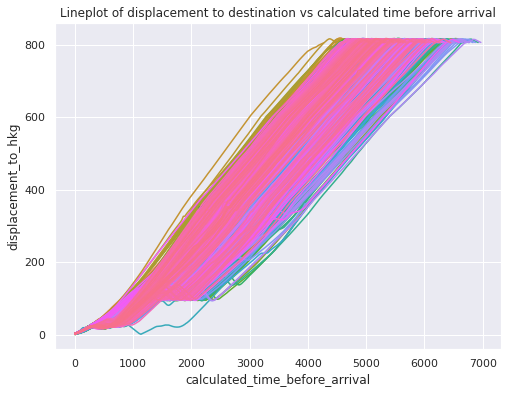

In [9]:
plt.figure(figsize=(8,6))
sns.lineplot(x="calculated_time_before_arrival", y="displacement_to_hkg", 
             hue='flight_id', legend=False, data=df_twn_hkg_flights)
plt.title('Lineplot of displacement to destination vs calculated time before arrival')
plt.savefig('../images/02a-modeling-every-time-point/{}.png'.format('01-lineplot-disp_vs_time'), transparent=True)

**Correlation of numerical variables**

In [10]:
corr_df = df_twn_hkg_flights[['timestamp_utc', 'latitude', 'longitude',
                              'altitude', 'heading', 'speed',
                              'scheduled_departure_utc', 'scheduled_arrival_utc',
                              'real_departure_utc', 'estimated_arrival_utc',
                              'real_flight_duration', 'scheduled_flight_duration',
                              'arrivals', 'time_since_real_departure', 
                              'prev_latitude', 'prev_longitude',
                              'calculated_flight_duration', 'calculated_time_before_arrival',
                              'displacement_to_hkg', 'displacement_fr_twn']].corr()

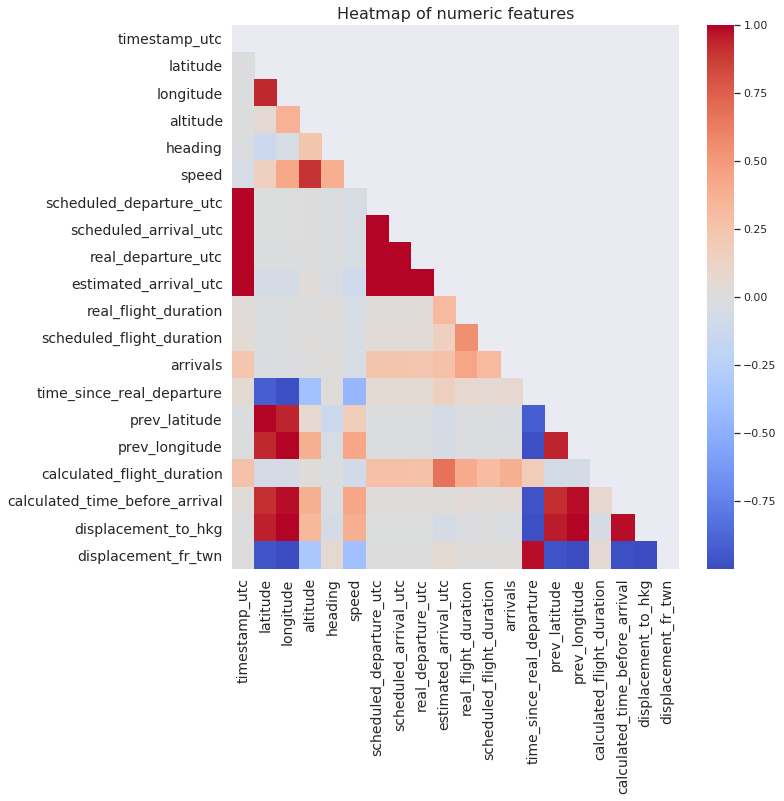

In [11]:
# Set the default matplotlib figure size to 7x7:
fig, ax = plt.subplots(figsize=(10, 10))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corr_df, mask=mask, ax=ax, cmap="coolwarm")

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

ax.set_title('Heatmap of numeric features', fontsize=16)

fig.savefig('../images/02a-modeling-every-time-point/{}.png'.format('02-heatmap'), transparent=True)
# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

In [12]:
corr_df['calculated_time_before_arrival'].sort_values().abs() > 0.5

displacement_fr_twn                True
time_since_real_departure          True
heading                           False
timestamp_utc                     False
real_departure_utc                False
estimated_arrival_utc             False
scheduled_flight_duration         False
scheduled_departure_utc           False
scheduled_arrival_utc             False
arrivals                          False
real_flight_duration              False
calculated_flight_duration        False
altitude                          False
speed                             False
latitude                           True
prev_latitude                      True
displacement_to_hkg                True
prev_longitude                     True
longitude                          True
calculated_time_before_arrival     True
Name: calculated_time_before_arrival, dtype: bool

<Figure size 864x576 with 0 Axes>

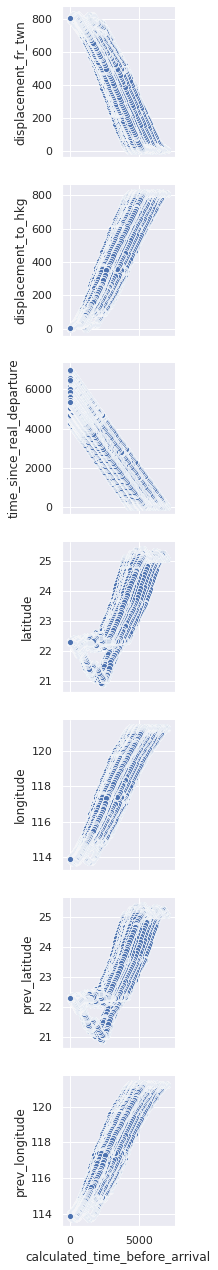

In [13]:
plt.figure(figsize=(12,8))
sns.pairplot(df_twn_hkg_flights, 
             y_vars=['displacement_fr_twn', 'displacement_to_hkg', 
                     'time_since_real_departure', 
                     'latitude', 'longitude',
                     'prev_latitude', 'prev_longitude'], 
             x_vars=['calculated_time_before_arrival'])
plt.savefig('../images/02a-modeling-every-time-point/{}.png'.format('03-scatterplot-target_vs_features'), transparent=True)

**ANOVA of categorical (nominal) variables**

In [14]:
f_values, p_values = f_classif(df_twn_hkg_flights[['flight_callsign', 'aircraft_model', 
                                                   'aircraft_registration', 'airline']]\
                               .apply(LabelEncoder().fit_transform), 
                               df_twn_hkg_flights['calculated_time_before_arrival'])

p_values

array([0.99999169, 0.11689826, 0.86909034, 0.70125192])

All levels or groups in the selected nominal variables have equal variance therefore it is likely not to have an impact on the target variable. Therefore they are omitted from the model.

## Feature Selection

In [15]:
selected_features = [
    'latitude', 'longitude', 
    'altitude', 'heading', 'speed',
#     'flight_callsign', 
#     'aircraft_registration', 
#     'aircraft_model', 'airline'
]

nominal_features = [
# #     'flight_callsign', 
#     'aircraft_model', 
#     'aircraft_registration',
#     'airline'
]

df_twn_hkg_flights[selected_features].head()

,latitude,longitude,altitude,heading,speed
0,25.090073,121.237190,950,46,143
1,25.093964,121.242012,1375,48,145
2,25.101013,121.251183,2100,50,153
3,25.103577,121.254631,2300,50,159
4,25.107010,121.259155,2525,50,171


In [16]:
# Train data

# mask = df_twn_hkg_flights['time_since_real_departure'] <= (140*60)
# df_for_modeling = df_twn_hkg_flights[mask].copy()
df_for_modeling = df_twn_hkg_flights.copy()
X = df_for_modeling[selected_features].copy()
y = df_for_modeling['calculated_time_before_arrival'].copy()

In [17]:
df_test_regression_metrics = pd.DataFrame()
df_test_true_pred = pd.DataFrame(columns=['model_name', 'true', 'pred'])

## Get dummies for nominal features

In [18]:
X = pd.get_dummies(X, columns=nominal_features, drop_first=True)

## Train-test split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

## Baseline Model

In [20]:
y_test_pred = np.repeat(np.mean(y_train), X_test.shape[0])
test_regression_metrics = get_regression_metrics(y_test, y_test_pred, X_test.shape[1])
test_regression_metrics['model_name'] = 'Baseline'
df_test_regression_metrics = df_test_regression_metrics.append(test_regression_metrics, ignore_index=True)

Mean squared error      =  3648066.108812868
Root mean squared error =  1909.9911279408782
Median absolute error   =  1666.5
R^2                     =  -0.00028106195046584403
Adjusted R^2            =  -0.0004266717475356341


## Modeling

In [21]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

joblib.dump(linreg, '../models/02a-linear-reg.pkl')

['../models/02a-linear-reg.pkl']

In [22]:
y_test_pred = linreg.predict(X_test)

test_regression_metrics = get_regression_metrics(y_test, y_test_pred, X_test.shape[1])
test_regression_metrics['model_name'] = 'Linear Regression'
df_test_regression_metrics = df_test_regression_metrics.append(test_regression_metrics, ignore_index=True)

Mean squared error      =  130799.21666387893
Root mean squared error =  361.6617434342191
Median absolute error   =  184.1625879357307
R^2                     =  0.9641355240162
Adjusted R^2            =  0.9641303032644847


In [23]:
df_test_true_pred = pd.DataFrame(columns=['true', 'pred'])
df_test_true_pred = df_test_true_pred.assign(true=y_test)
df_test_true_pred = df_test_true_pred.assign(pred=y_test_pred)
df_test_true_pred['diff'] = df_test_true_pred['true'] - df_test_true_pred['pred']
df_test_true_pred.shape

(34354, 3)

In [24]:
df_test_true_pred[df_test_true_pred['diff'] < 0].shape # if true < pred => late

(17557, 3)

In [25]:
df_test_true_pred[df_test_true_pred.pred < 0].shape

(0, 3)

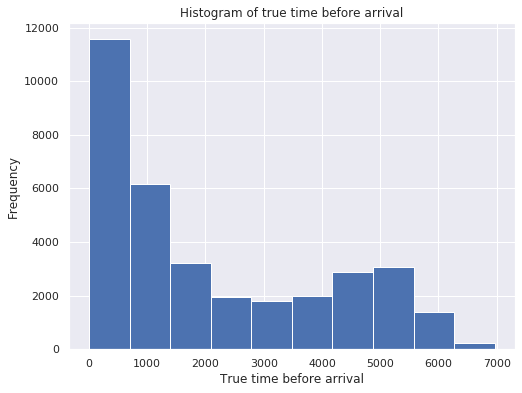

In [26]:
plt.figure(figsize=(8,6))
plt.title('Histogram of true time before arrival')
df_test_true_pred.true.hist()
plt.xlabel('True time before arrival')
plt.ylabel('Frequency')
plt.savefig('../images/02a-modeling-every-time-point/{}.png'.format('04-histogram-true'), transparent=True)

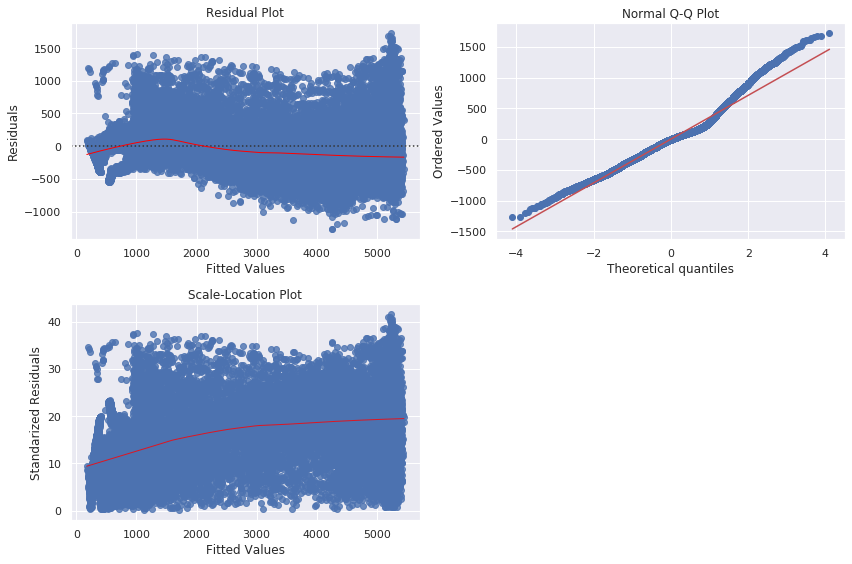

In [27]:
regression_diagnostic_plots(df_test_true_pred[df_test_true_pred['true'] > 0], '05-linreg-diagnostic')

**Standardization of features**

In [28]:
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

## Ridge Regression

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1985s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1507s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 106 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 220 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:    2.5s
[Parallel(n_j

Ridge Regression
Best Score: 0.9637537298587174
Best Params: {'reg__alpha': 1.0}

Mean squared error      =  130799.84077768281
Root mean squared error =  361.662606275079
Median absolute error   =  184.20110047063076
R^2                     =  0.9641353528873882
Adjusted R^2            =  0.9641301321107618


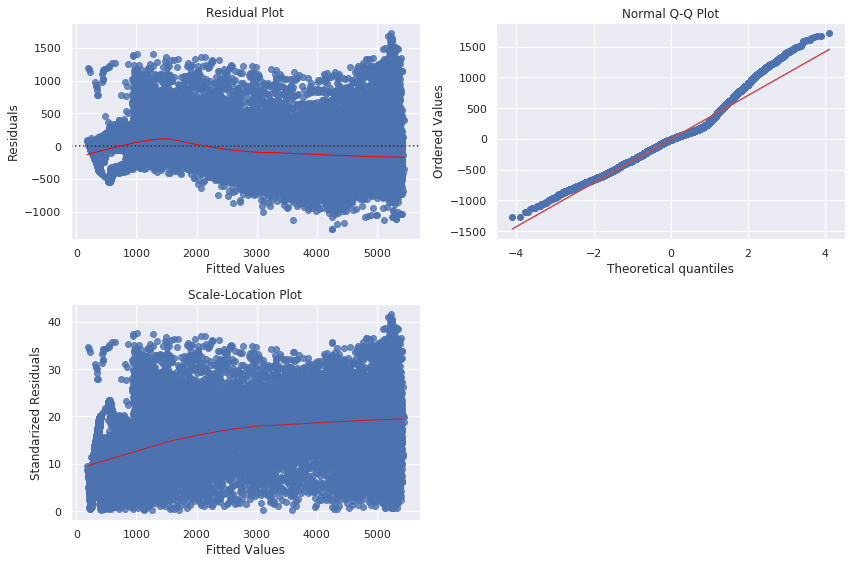

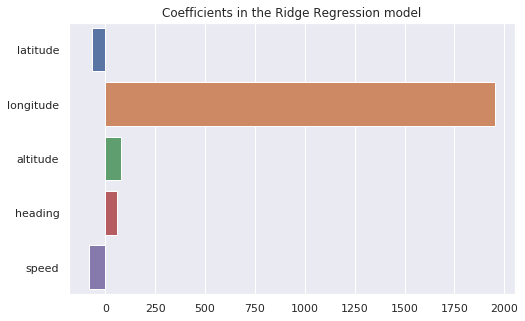

In [29]:
test_regression_metrics, y_test_pred, grid_model = gridsearch_model_evaluation('Ridge Regression',
                                                                    Ridge(),
                                                                    {'reg__alpha': np.logspace(0, 5, 200)},
                                                                    '../models/02a-ridge-reg.pkl',
                                                                    '06-ridge-diagnostic'
                                                                  )

df_test_regression_metrics = df_test_regression_metrics.append(test_regression_metrics, ignore_index=True)
plot_coefficients(grid_model.named_steps["reg"].coef_, '06-ridge-coef', 'Ridge Regression')

## Lasso Regression

In [ ]:
test_regression_metrics, y_test_pred, grid_model = gridsearch_model_evaluation('Lasso Regression',
                                                                                Lasso(),
                                                                                {'reg__alpha': np.arange(0.001, 0.15, 0.0025)},
                                                                                '../models/02a-lasso-reg.pkl',
                                                                                '07-lasso-diagnostic'
                                                                               )

df_test_regression_metrics = df_test_regression_metrics.append(test_regression_metrics, ignore_index=True)
plot_coefficients(grid_model.named_steps["reg"].coef_, '07-lasso-coef', 'Lasso Regression')

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

Lasso Regression
Best Score: 0.9637537323310031
Best Params: {'reg__alpha': 0.001}

Mean squared error      =  130799.26865230512
Root mean squared error =  361.66181530859063
Median absolute error   =  184.16298306275883
R^2                     =  0.9641355097612395
Adjusted R^2            =  0.9641302890074491


## ElasticNet Regression

In [ ]:
test_regression_metrics, y_test_pred, grid_model = gridsearch_model_evaluation('ElasticNet Regression',
                                                                    ElasticNet(),
                                                                    {'reg__alpha': np.arange(0.5, 1.0, 0.005),
                                                                     'reg__l1_ratio': [0.2]},
                                                                     '../models/02a-elasticnet-reg.pkl',
                                                                     '08-elasticnet-diagnostic')

df_test_regression_metrics = df_test_regression_metrics.append(test_regression_metrics, ignore_index=True)
plot_coefficients(grid_model.named_steps["reg"].coef_, '08-elasticnet-coef', 'ElasticNet Regression')

## Random Forest Regression

In [ ]:
# https://gdcoder.com/decision-tree-regressor-explained-in-depth/
# https://medium.com/datadriveninvestor/random-forest-regression-9871bc9a25eb
test_regression_metrics, y_test_pred, grid_model = gridsearch_model_evaluation('Random Forest Regression',
                                                                    RandomForestRegressor(),
                                                                    {'reg__max_depth': range(3,7),
                                                                     'reg__n_estimators': np.arange(10, 70, 10)},
                                                                    '../models/02a-random-forest-reg.pkl',
                                                                    '09-rf-diagnostic'
                                                                   )

df_test_regression_metrics = df_test_regression_metrics.append(test_regression_metrics, ignore_index=True)

In [ ]:
var_imp_plot(imp_df(X_train.columns, grid_model.named_steps["reg"].feature_importances_),
             'Feature Importance Plot',
             '09-rf-feature_importance')

## AdaBoost Regression

In [ ]:
# https://www.programcreek.com/python/example/86712/sklearn.ensemble.AdaBoostRegressor
ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor()) 
test_regression_metrics, y_test_pred, grid_model = gridsearch_model_evaluation('AdaBoost Regression',
                                                                    ada,
                                                                    {'reg__n_estimators': [25, 50],
                                                                     'reg__base_estimator__max_depth': [1,2],
                                                                     'reg__learning_rate': np.arange(0.4, 1.1, 0.1)},
                                                                    '../models/02a-adaboost-reg.pkl',
                                                                    '10-adaboost-diagnostic'
                                                                   )

df_test_regression_metrics = df_test_regression_metrics.append(test_regression_metrics, ignore_index=True)

In [ ]:
var_imp_plot(imp_df(X_train.columns, grid_model.named_steps["reg"].feature_importances_),
             'Feature Importance Plot',
             '10-adaboost-feature_importance')

## Final Regression Metrics

In [ ]:
df_test_regression_metrics[['model_name', 'mse', 'rmse', 'mae', 'r2', 'r2_adjusted']].sort_values(by='rmse').reset_index(drop=True)

The random forest regression model performs the best out of the 7 different models in terms of RMSE.